In [1]:
import numpy as np
import pandas as pd
import data_lib
import plot_lib
import decision_lib
from sklearn import cluster
import validation_lib
import transform_lib

np.random.seed(200)

In [2]:
# print available data summary
data_dict = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-2-labelled/droplet-level-data/RawData
po-di-se-2-A4, files: 13                po-di-se-2-C4, files: 13                po-di-se-2-A1, files: 13
po-di-se-2-B1, files: 13                po-di-se-2-D1, files: 13                po-di-se-2-B4, files: 13
po-di-se-2-C1, files: 13                po-di-se-2-D4, files: 13                
-----------------------------------
Group: ../../Data/6P-positive-dilution-series-1-labelled/droplet-level-data/RawData
po-di-se-1-D4, files: 13                po-di-se-1-A4, files: 13                po-di-se-1-A1, files: 13
po-di-se-1-D1, files: 13                po-di-se-1-B1, files: 13                po-di-se-1-C1, files: 13
po-di-se-1-B4, files: 13         

### Get samples for negative control

In [3]:


# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    #"po-di-se-2-A4", 
    #"po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    #"po-di-se-2-D1",
    #"po-di-se-2-D4",
    #"po-di-se-2-A1", "po-di-se-2-B4",

    #"po-di-se-1-D4",
    #"po-di-se-1-D1",
    #"po-di-se-1-B4", 
    "po-di-se-1-A4",
    #"po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", 
    #"po-di-se-1-C1",

    #"po-di-se-B8",
    #"po-di-se-D8",
    #"po-di-se-A8",
    #"po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1",
    "po-di-se-1-D4",
    "po-di-se-2-D1", 
    "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = None # df_negative_control.to_numpy()

In [4]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
whitening_engine = transform_lib.WhitenTransformer(whiten=transform_lib.Whitenings.NONE)
num_cluster = int(2**len(prediction_axis) * 2)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = cluster.DBSCAN(eps=0.2, n_jobs=4, min_samples=6, leaf_size=5)
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.WhitnesDensityClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     negative_range=0.95,
                                     eps=0.2,
                                     outlier_quantile=0.004,
                                     prediction_axis=prediction_axis,
                                     verbose=True
                                     )
df_decision = decision.predict(np_di)

Finished compute clusters in 0.4286630153656006 seconds
Finished compute transformed features in 0.10073542594909668 seconds
Finished predict cluster labels in 0.7296371459960938 seconds


/home/nico/edu/semiv/lab/code/libs/decision_lib/whitnes_density_classifier.py:295: RuntimeWarning: overflow encountered in exp
  in_range = 1 / (1 + np.exp(scaled_avg_dist_))


Finished predict labels in 0.01752495765686035 seconds


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.004008717988635479, n_outlier: 103

Total error rate: 0.014304797559078111
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.002661      0.04957   0.013224   0.005552   0.005871 0.008952

Precision (TP / (TP + FP)): 0.9989176226348246
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999113     0.998798   0.996432   0.999941   0.999827 0.998741

Recall / TPR (TP / (TP + FN)): 0.9990137767040137
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999746     0.998558   0.997873    0.99852   0.999476 0.999729

Specificity / TNR (TN / (TN + FP)): 0.998690325513309
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999238     0.999022   0.996632   0.999897   0.999643 0.998296

Accuracy ((TP + TN) / (P + N)): 0.9988674108560454
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999473     0.998814   0.997234   0.999021    0.99953  0.99912

F1 (2 * (precision * r

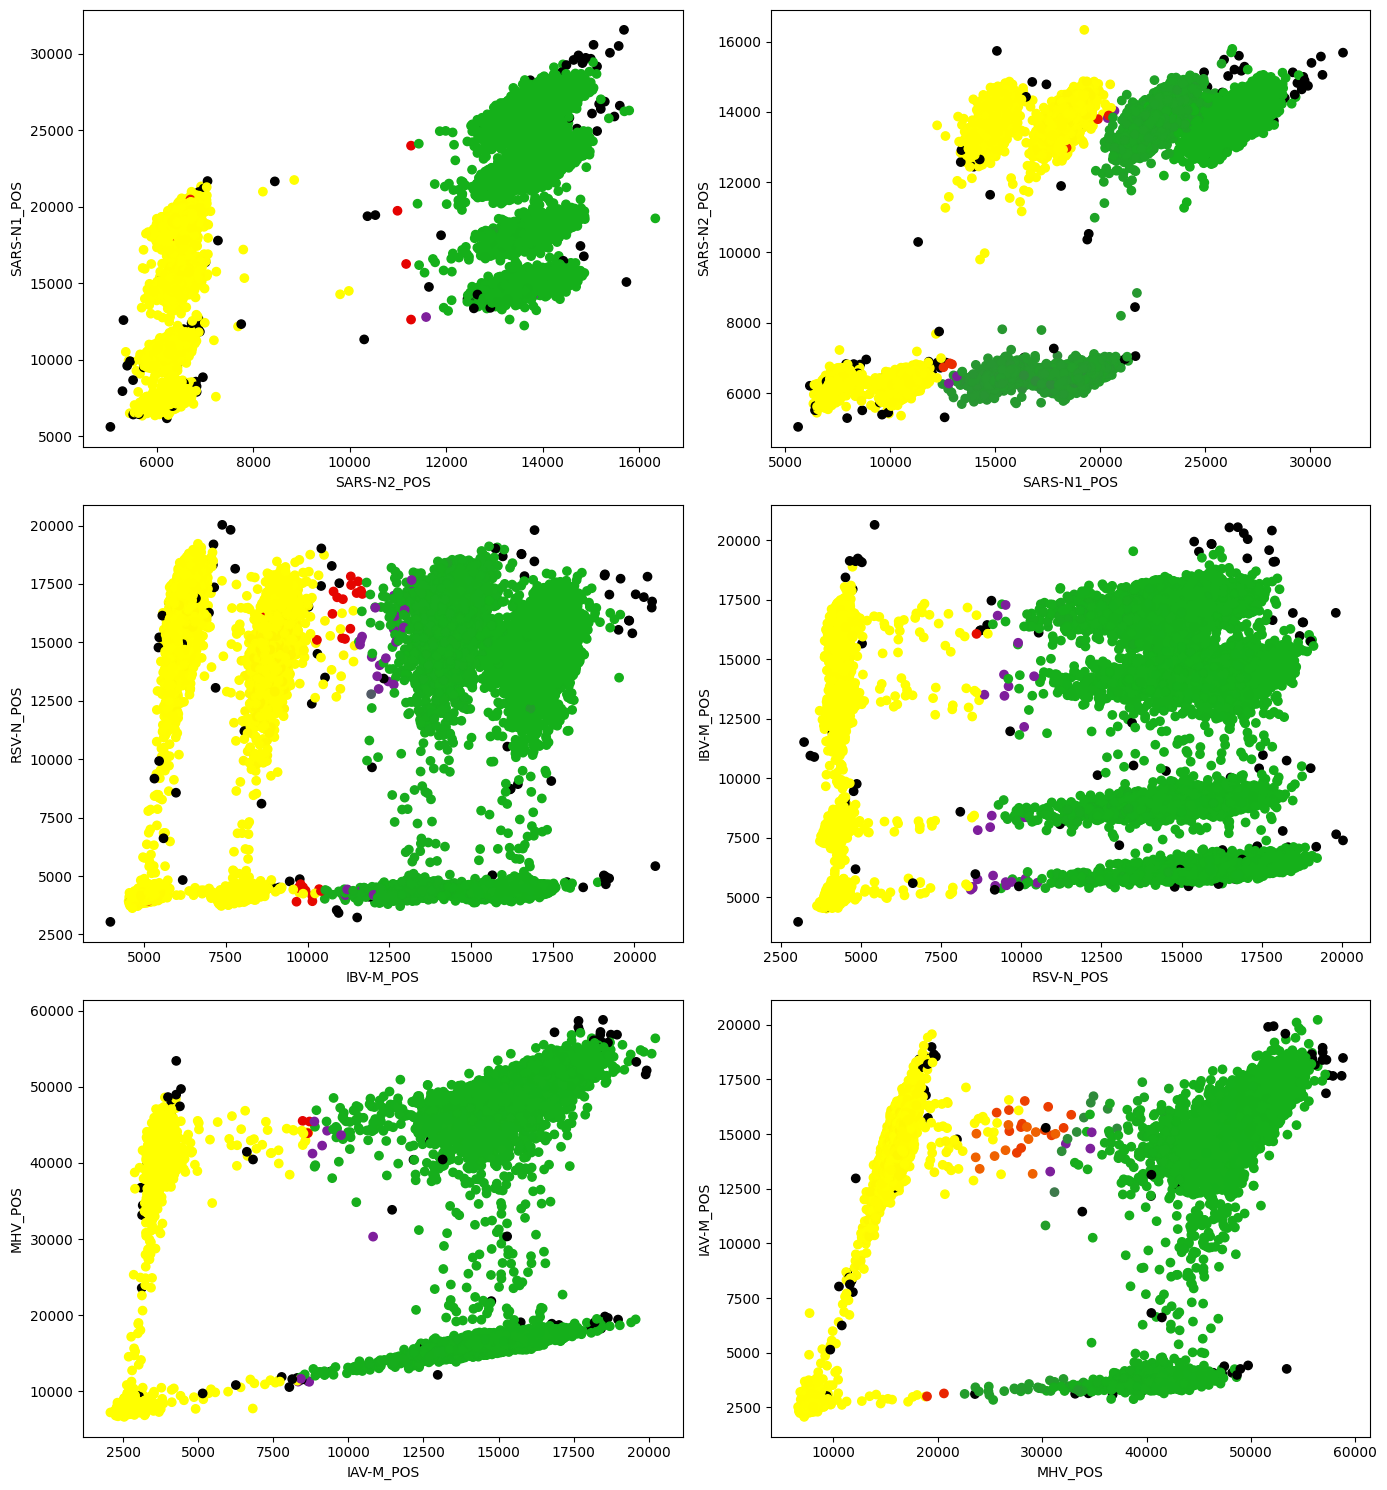

In [5]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = decision.probabilities_df
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]

mask = decision.No_neg_mask
validation_lib.validate_labels(df_true_labels=df_di, df_predicted_labels=df_predictions, verbosity=1, threshold=0.5)

#df_result = stats_lib.compute_results(df_predictions, 0.40, 0.60, df_data_points)

plot_lib.plot_pairwise_selection_bayesian(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

In [6]:
validation_lib.validate_combinations(df_di, df_predictions, verbosity=0)

Total number of outlayer: 103

Label combination ('SARS-N2_POS',):
n outliers: 1, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N1_POS',):
n outliers: 0, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('IBV-M_POS',):
n outliers: 1, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('RSV-N_POS',):
n outliers: 4, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('IAV-M_POS',):
n outliers: 1, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('MHV_POS',):
n outliers: 1, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'SARS-N1_POS'):
n outliers: 1, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'IBV-M_POS'):
n outliers: 0, n_true_pos: 0
Balanced Accuracy: No evaluation possible

Label combination ('SARS-N2_POS', 'RSV-N_POS'):
n outliers: 3, n_true_pos: 0
Balanced Acc

In [7]:
#df_result.to_csv("test_di.csv")

In [8]:
decision.assign_true_cluster_labels(df_gt=df_ground_trouth)
print(-2, decision.prediction_axis)
for c in decision.cluster_dict.keys():
    #print(c, decision.cluster_dict[c].active)
    pass

-2 ['SARS-N2_POS', 'SARS-N1_POS', 'IBV-M_POS', 'RSV-N_POS', 'IAV-M_POS', 'MHV_POS']


(Partially) falsely classified clusters [1]


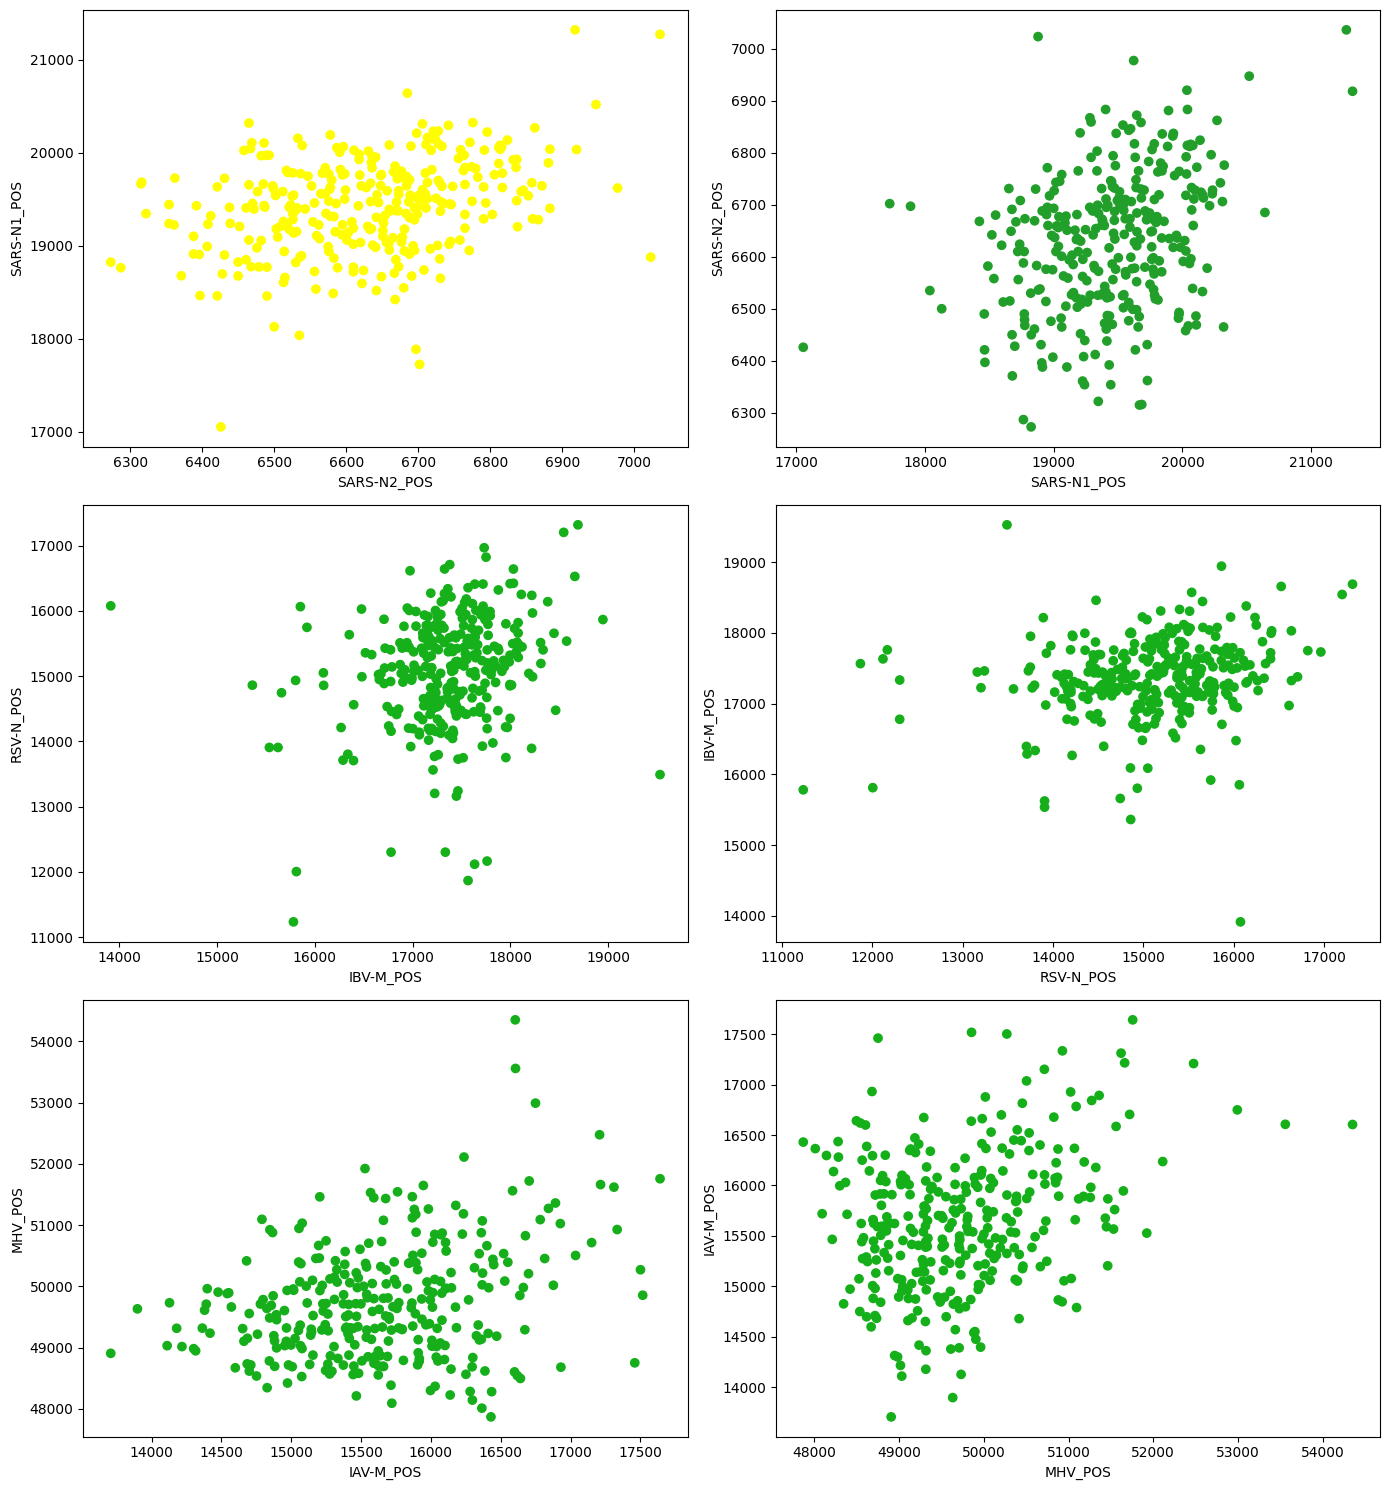

In [9]:

false_clusters = [1]
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)

In [10]:
validation_lib.get_negative_percent(df_ground_trouth, prediction_axis)

ic| negative_count.shape: (6,)
ic| negative_percent.shape: (6,)
ic| axis: ['SARS-N2_POS', 'SARS-N1_POS', 

'IBV-M_POS', 'RSV-N_POS', 'IAV-M_POS', 'MHV_POS']
ic| all_neg.shape: ()
ic| all_neg_per.shape: ()
ic| np.var(np_points, axis=0): array([0.24858066, 0.24912279, 0.24981761, 0.23128511, 0.21931299,
                                      0.24442771])


Positive count: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
0        11879        12086      12500      16362      17348    14765
Positive percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.462326     0.470382   0.486495   0.636802   0.675177  0.574648
Negative percent: 
   SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS   MHV_POS
0     0.537674     0.529618   0.513505   0.363198   0.324823  0.425352
All neg Count count: 
195
All neg percent: 
0.007589320463921538
All pos percent: 
0.9924106795360784
